# Importer les librairies nécessaires

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from sklearn.metrics import f1_score
from tensorflow.keras.regularizers import l1, l2, l1_l2
import joblib

## Importer le Dataset sous format pandas dataframe

In [3]:
dataset = pd.read_csv('/content/Depression Student Dataset.csv')

# Analyse Exploratrice des données

* Visualisation des 5 premieres lignes

In [6]:
dataset.head()

,Gender,Age,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Male,28,2.0,4.0,7-8 hours,Moderate,Yes,9,2,Yes,No
1,Male,28,4.0,5.0,5-6 hours,Healthy,Yes,7,1,Yes,No
2,Male,25,1.0,3.0,5-6 hours,Unhealthy,Yes,10,4,No,Yes
3,Male,23,1.0,4.0,More than 8 hours,Unhealthy,Yes,7,2,Yes,No
4,Female,31,1.0,5.0,More than 8 hours,Healthy,Yes,4,2,Yes,No


* Affichage des colonnes du dataset

In [7]:
dataset.keys()

Index(['Gender', 'Age', 'Academic Pressure', 'Study Satisfaction',
       'Sleep Duration', 'Dietary Habits',
       'Have you ever had suicidal thoughts ?', 'Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object')

* Affichage des info sur les colonnes du dataset

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 502 non-null    object 
 1   Age                                    502 non-null    int64  
 2   Academic Pressure                      502 non-null    float64
 3   Study Satisfaction                     502 non-null    float64
 4   Sleep Duration                         502 non-null    object 
 5   Dietary Habits                         502 non-null    object 
 6   Have you ever had suicidal thoughts ?  502 non-null    object 
 7   Study Hours                            502 non-null    int64  
 8   Financial Stress                       502 non-null    int64  
 9   Family History of Mental Illness       502 non-null    object 
 10  Depression                             502 non-null    object 
dtypes: flo

* Affichage du nombre d'exemple dans le dataset: dans notre cas 502

In [9]:
dataset.shape[0]

502

* Voir la répartition des valeurs de la variable à prédire

Dans notre cas on a une répartition équilibrée, ce qui est bénéfique pour l'entrainement du modèle en réduisant les risques de biais envers la classe majoritaire

In [10]:
dataset["Depression"].value_counts()

,count
Depression,
Yes,252
No,250


* Affichage des histogrames des features numériques

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Academic Pressure'}>],
       [<Axes: title={'center': 'Study Satisfaction'}>,
        <Axes: title={'center': 'Study Hours'}>],
       [<Axes: title={'center': 'Financial Stress'}>, <Axes: >]],
      dtype=object)

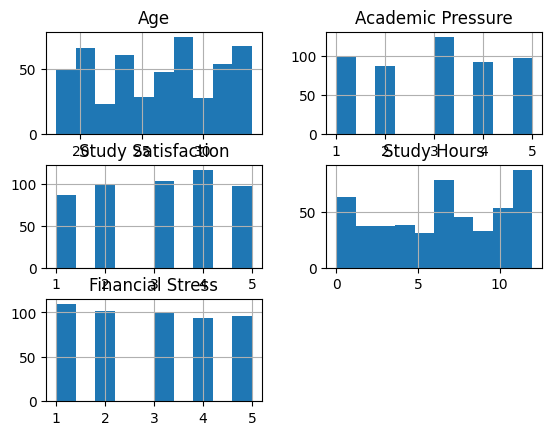

In [11]:
dataset.hist()

On remarque une répartission assez uniforme des données sans présence d'outlier

* Affichage de la corrélation de la target avec les autres features

In [12]:
def calculate_correlations_simple(dataset, target_column):
    """
    Calculates correlations with label encoding for categoricals.
    """

    num_features = dataset.select_dtypes(include=['int64', 'float64']).columns
    cat_features = dataset.select_dtypes(include=['object']).columns

    # Create a copy to avoid modifying the original DataFrame
    dataset_encoded = dataset.copy()

    # Label encode categorical features
    for col in cat_features:
        dataset_encoded[col] = dataset_encoded[col].astype('category').cat.codes

    # Calculate correlations
    correlations = dataset_encoded.corr()[target_column]
    correlations = correlations.drop(target_column)  # Remove self-correlation

    return correlations


target = "Depression"
correlations = calculate_correlations_simple(dataset, target)

if correlations is not None:
    # Sort by absolute value to see strongest relationships
    sorted_correlations = correlations.abs().sort_values(ascending=False)
    print("\nSorted Correlations (absolute value):")
    print(sorted_correlations)


Sorted Correlations (absolute value):
Academic Pressure                        0.476259
Have you ever had suicidal thoughts ?    0.466296
Financial Stress                         0.296846
Study Satisfaction                       0.293484
Age                                      0.215625
Study Hours                              0.200441
Dietary Habits                           0.186685
Family History of Mental Illness         0.056087
Sleep Duration                           0.051708
Gender                                   0.031683
Name: Depression, dtype: float64


* Description des données numériques

In [13]:
dataset.describe()

,Age,Academic Pressure,Study Satisfaction,Study Hours,Financial Stress
count,502.000000,502.000000,502.000000,502.000000,502.000000
mean,26.241036,3.003984,3.075697,6.404382,2.928287
std,4.896501,1.390007,1.373490,3.742434,1.425053
min,18.000000,1.000000,1.000000,0.000000,1.000000
25%,22.000000,2.000000,2.000000,3.000000,2.000000
50%,26.500000,3.000000,3.000000,7.000000,3.000000
75%,30.000000,4.000000,4.000000,10.000000,4.000000
max,34.000000,5.000000,5.000000,12.000000,5.000000


* Affichage d'un boxplot des Ages groupé par Genre pour voir la distribution.

<Axes: title={'center': 'Age'}, xlabel='Gender'>

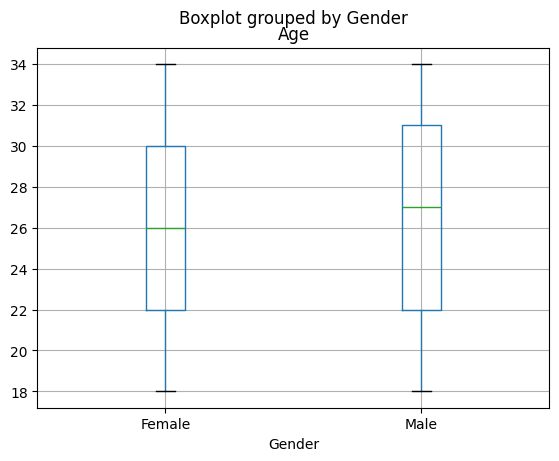

In [14]:
dataset.boxplot(column='Age',by='Gender')

* Affichage d'un camembert de la variable à prédire

<Axes: ylabel='count'>

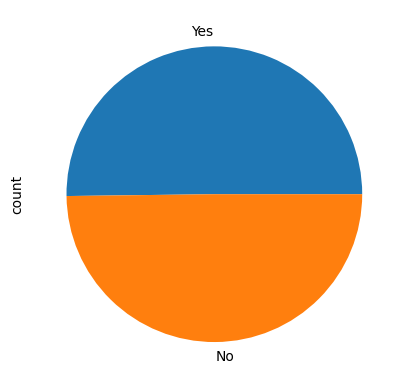

In [15]:
dataset['Depression'].value_counts().plot.pie()

* Visualisation des histogrammes pour les 2 types de variables en fonction de la target

<ipython-input-16-59e558ada9e4>:17: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(dataset[column]) or pd.api.types.is_object_dtype(dataset[column]):


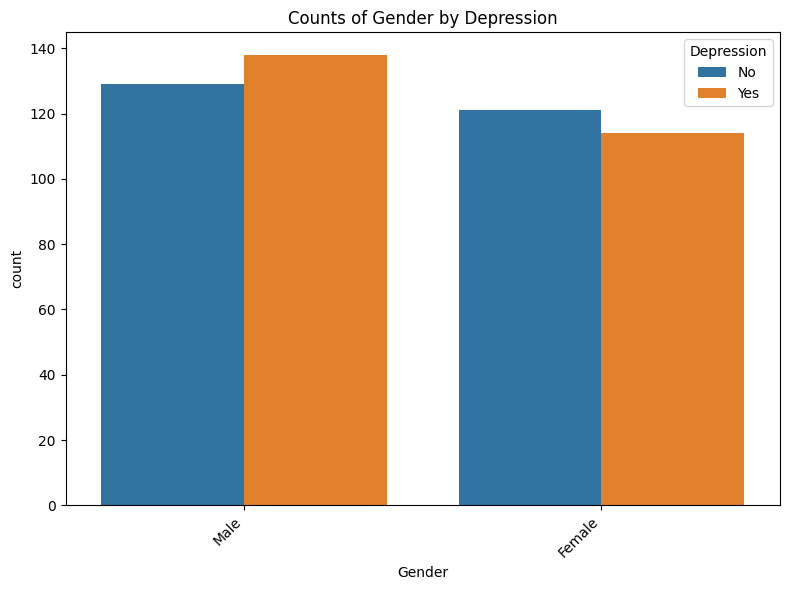

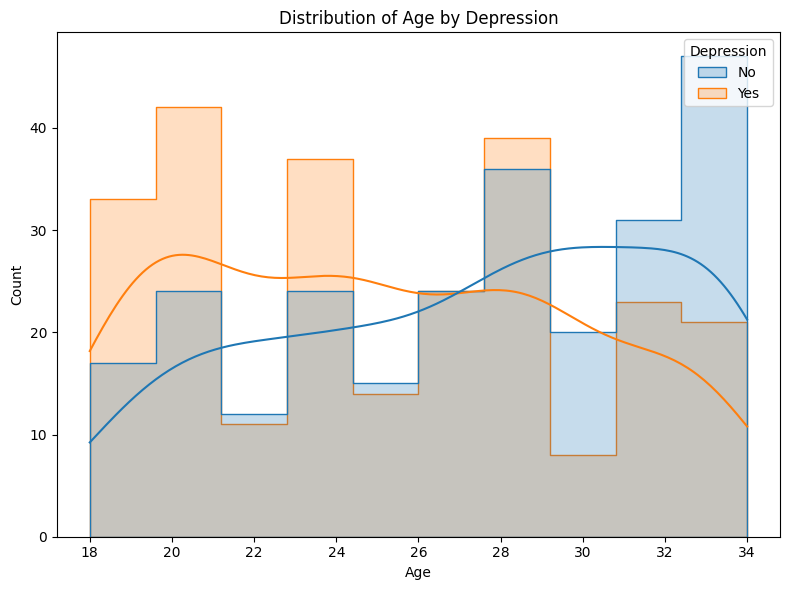

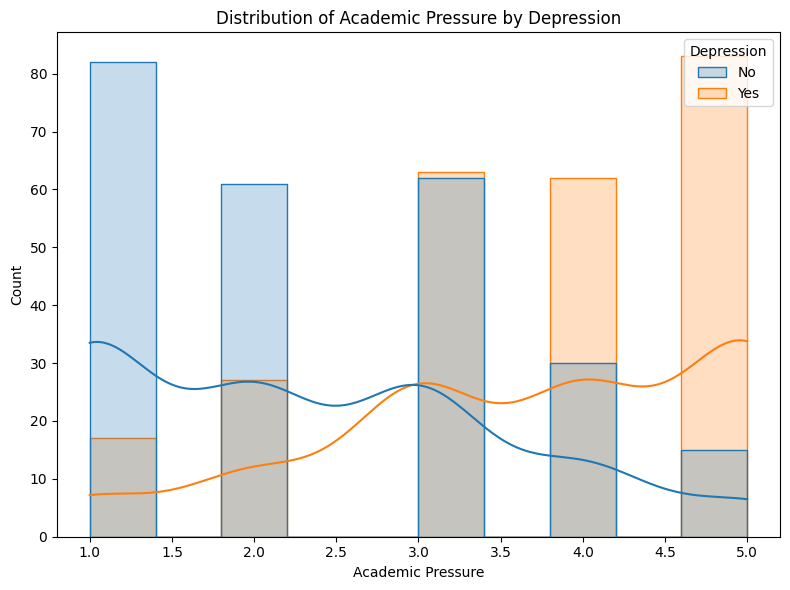

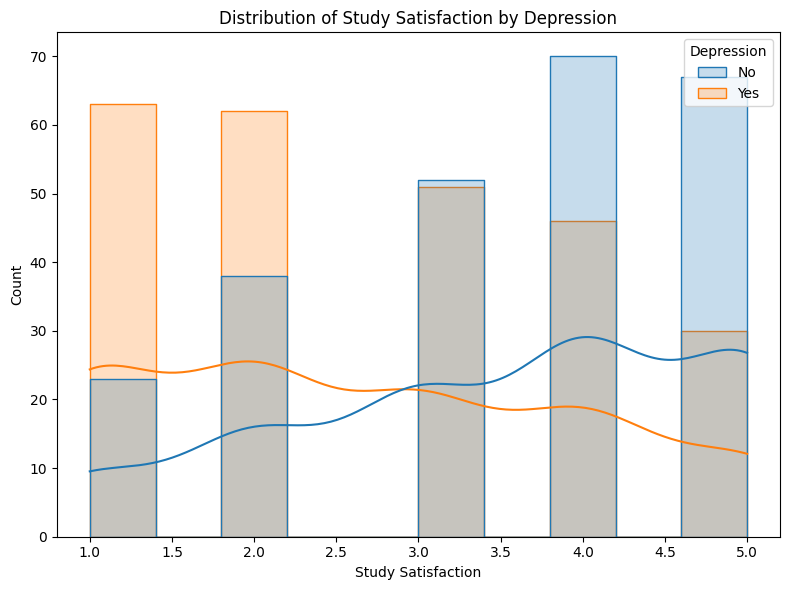

<ipython-input-16-59e558ada9e4>:17: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(dataset[column]) or pd.api.types.is_object_dtype(dataset[column]):


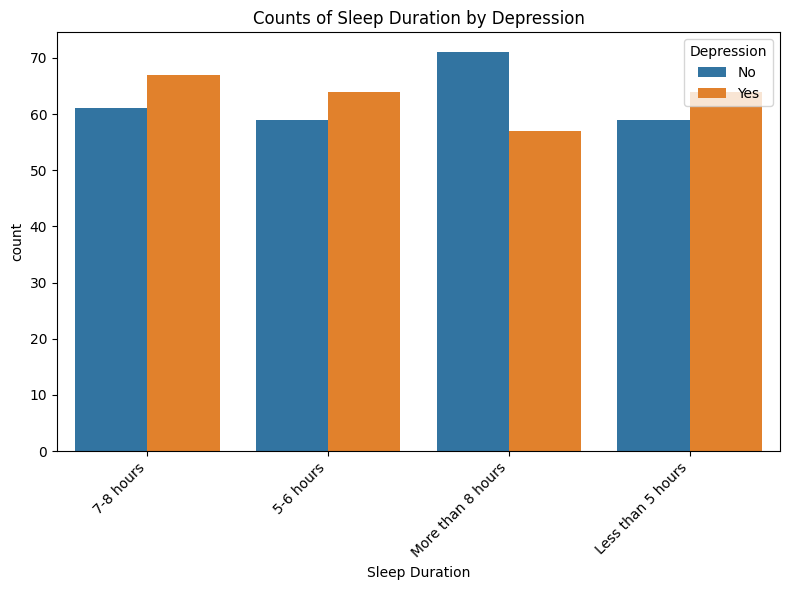

<ipython-input-16-59e558ada9e4>:17: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(dataset[column]) or pd.api.types.is_object_dtype(dataset[column]):


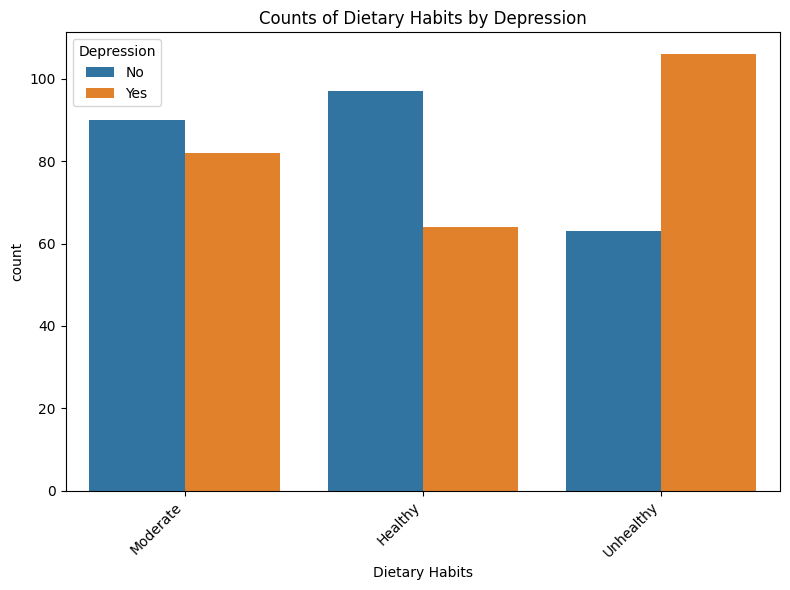

<ipython-input-16-59e558ada9e4>:17: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(dataset[column]) or pd.api.types.is_object_dtype(dataset[column]):


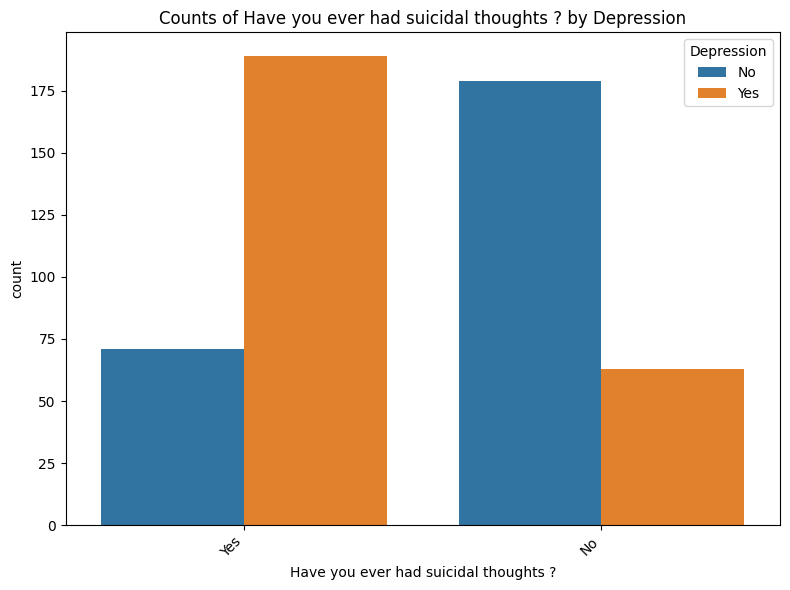

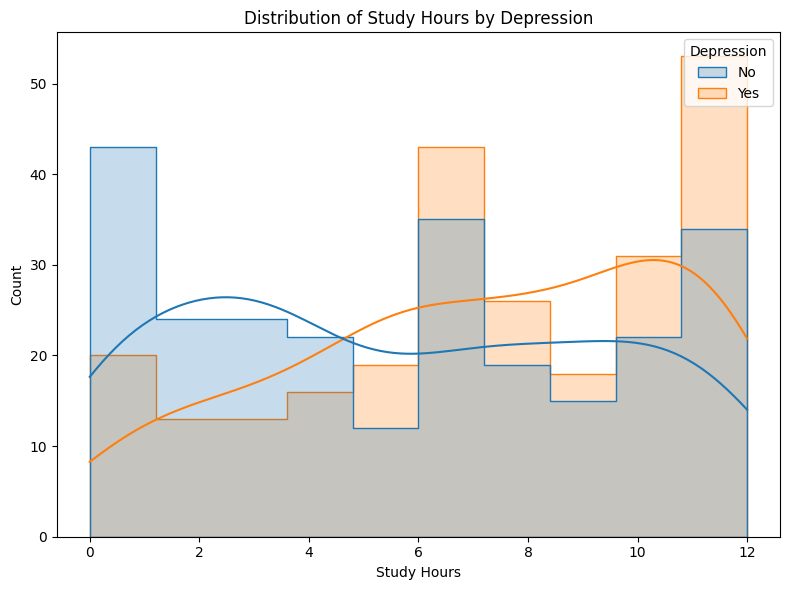

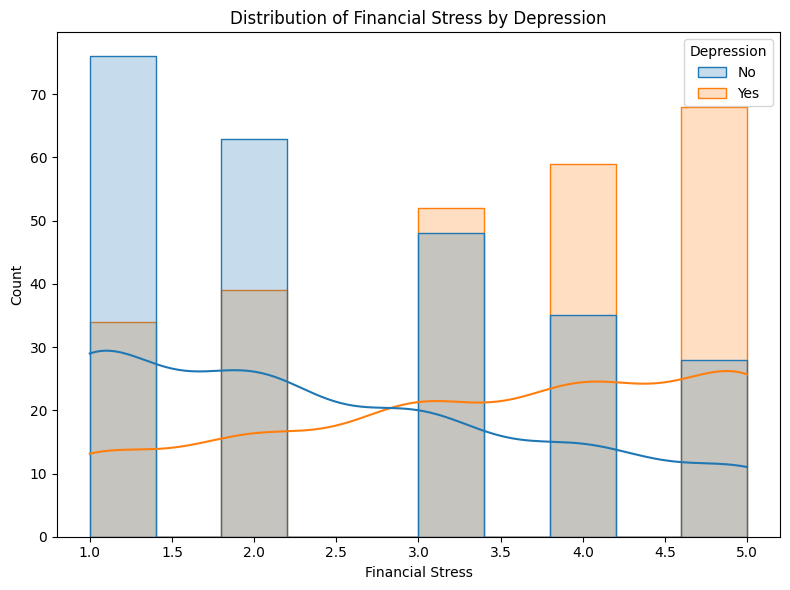

<ipython-input-16-59e558ada9e4>:17: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(dataset[column]) or pd.api.types.is_object_dtype(dataset[column]):


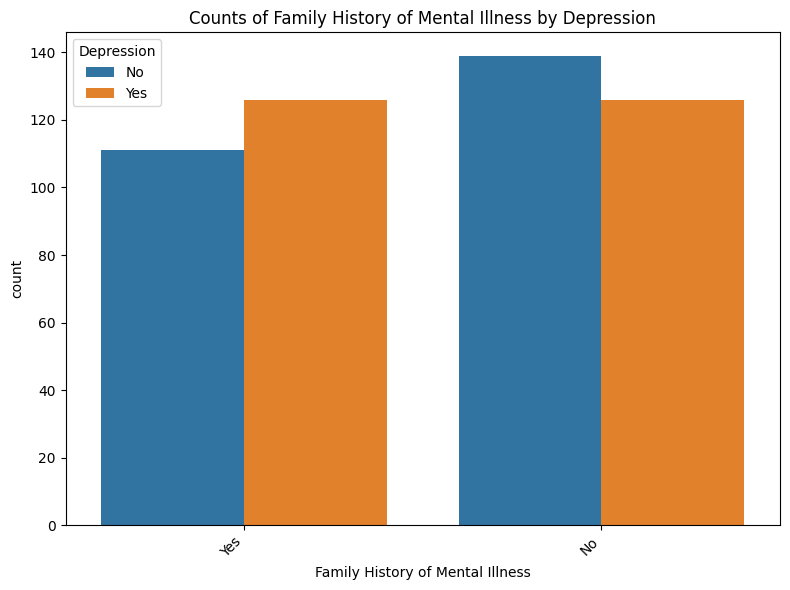

In [16]:
def visualize_histograms(dataset, target_column):
    """Visualizes histograms or bins for each feature with the target."""

    if target_column not in dataset.columns:
        print(f"Error: Target column '{target_column}' not found in the dataset.")
        return

    for column in dataset.columns:
        if column != target_column:
            plt.figure(figsize=(8, 6))  # Adjust figure size as needed

            if pd.api.types.is_numeric_dtype(dataset[column]):
                # Numerical feature: Histogram
                sns.histplot(data=dataset, x=column, hue=target_column, kde=True, element="step")  # KDE for smoother visualization
                plt.title(f"Distribution of {column} by {target_column}")

            elif pd.api.types.is_categorical_dtype(dataset[column]) or pd.api.types.is_object_dtype(dataset[column]):
                # Categorical feature: Countplot (bins)
                sns.countplot(data=dataset, x=column, hue=target_column)
                plt.title(f"Counts of {column} by {target_column}")
                plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed

            plt.tight_layout()
            plt.show()


target = "Depression"
visualize_histograms(dataset, target)

# Preprocessing des données:
  * Standardisation des variables numériques
  * Encodage des variables catégoriques

In [17]:
def preprocess_data(dataset, target_column):
    """Encodes categorical features and Z-scales numerical features, including the target."""

    if target_column not in dataset.columns:
        print(f"Error: Target column '{target_column}' not found in the dataset.")
        return None

    dataset_processed = dataset.copy()

    # Separate features and target
    X = dataset_processed.drop(target_column, axis=1)
    y = dataset_processed[target_column]

    # Identify numerical and categorical features
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns

    # Initialize encoders and scalers
    label_encoders = {}
    scaler = StandardScaler()
    target_encoder = None  # Initialize target encoder

    # Encode categorical features
    all_categorical_cols = list(categorical_cols)
    if pd.api.types.is_object_dtype(y):
        all_categorical_cols.append(target_column)
        target_encoder = LabelEncoder() # Create a separate encoder for the target
        y = target_encoder.fit_transform(y)


    for col in all_categorical_cols:  # Encode all categorical columns
        if col != target_column: # features
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
            label_encoders[col] = le



    # Z-scale numerical features
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

    # Combine preprocessed features and target back into a DataFrame
    dataset_processed = pd.concat([X, pd.Series(y, name=target_column)], axis=1)

    return dataset_processed, label_encoders, scaler, target_encoder


target = "Depression"
dataset_preprocessed, feature_encoders, scaler, target_encoder = preprocess_data(dataset, target)

if dataset_preprocessed is not None:
    print(dataset_preprocessed.head())

   Gender       Age  Academic Pressure  Study Satisfaction  Sleep Duration  \
0       1  0.359587          -0.723007            0.673631               1   
1       1  0.359587           0.717269            1.402429               0   
2       1 -0.253706          -1.443146           -0.055168               0   
3       1 -0.662569          -1.443146            0.673631               3   
4       0  0.972881          -1.443146            1.402429               3   

   Dietary Habits  Have you ever had suicidal thoughts ?  Study Hours  \
0               1                                      1     0.694256   
1               0                                      1     0.159311   
2               2                                      1     0.961728   
3               2                                      1     0.159311   
4               0                                      1    -0.643106   

   Financial Stress  Family History of Mental Illness  Depression  
0         -0.652055     

# Division des données en Train et Test set avec un test_size de 20%

In [18]:
X = dataset_preprocessed.drop('Depression', axis=1)
y = dataset_preprocessed['Depression']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

* Nous avons 401 exemples pour l'entrainement

In [19]:
X_train.shape[0]

401

* Et 101 exeemples pour le test

In [20]:
X_test.shape[0]

101

# Entrainement des Modèles

Un dictionnaire models est créé pour stocker les modèles de classification à évaluer. Il inclut :

- Régression logistique

- Classification naïve bayésienne

- K plus proches voisins

- Arbre de décision

- Forêt aléatoire

- Gradient boosting

- AdaBoost

- Machine à vecteurs de support

Les résultats (précision, rapport et matrice de confusion) sont stockés dans le dictionnaire results pour chaque modèle.

La matrice de confusion est générée à l’aide de seaborn.heatmap pour une représentation visuelle des performances du modèle.

In [21]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """Trains and evaluates multiple categorical classification models."""

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Naive Bayes": GaussianNB(),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "AdaBoost": AdaBoostClassifier(),
        "Support Vector Machine": SVC(),
    }

    results = {}

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, zero_division=1) # added zero division handling
        cm = confusion_matrix(y_test, y_pred)

        results[name] = {"accuracy": accuracy, "report": report, "confusion_matrix": cm}

        # Visualize confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

    return results


Training Logistic Regression...


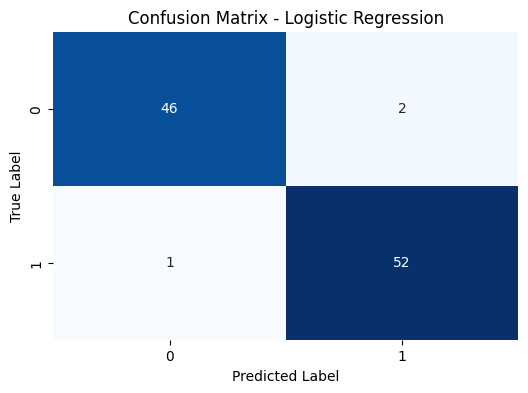

Training Naive Bayes...


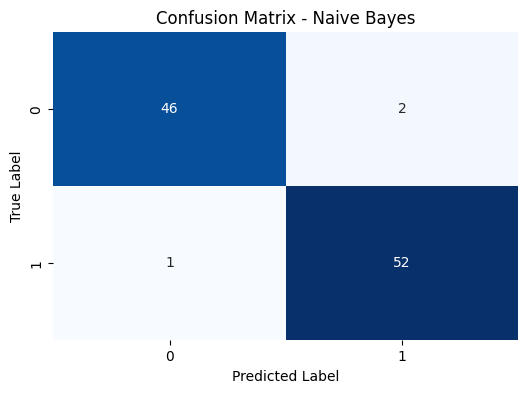

Training K-Nearest Neighbors...


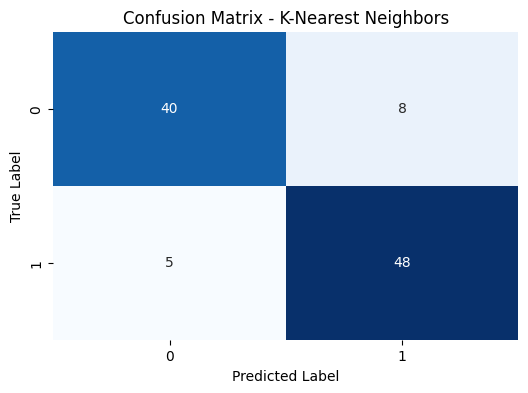

Training Decision Tree...


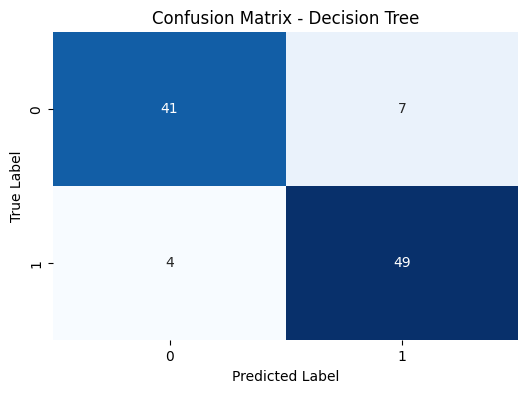

Training Random Forest...


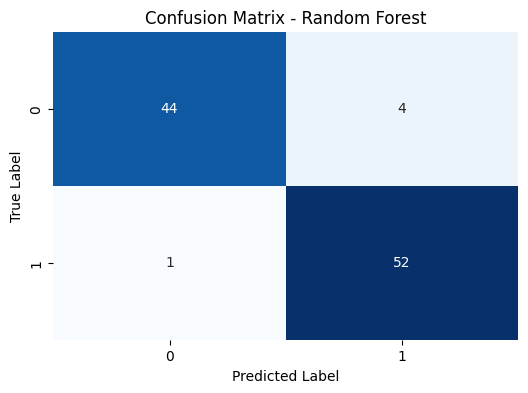

Training Gradient Boosting...


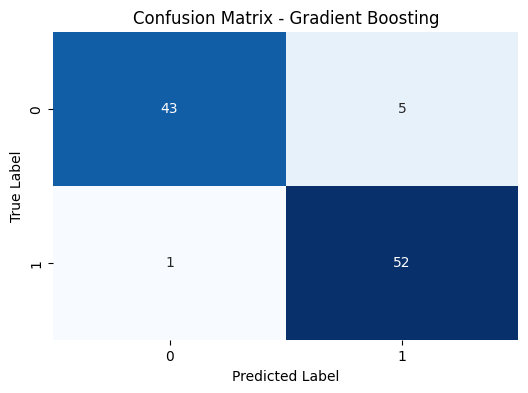

Training AdaBoost...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


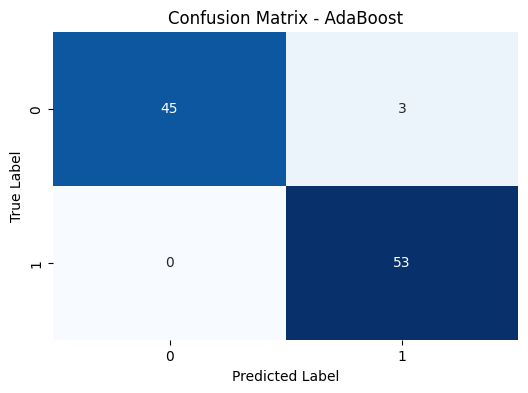

Training Support Vector Machine...


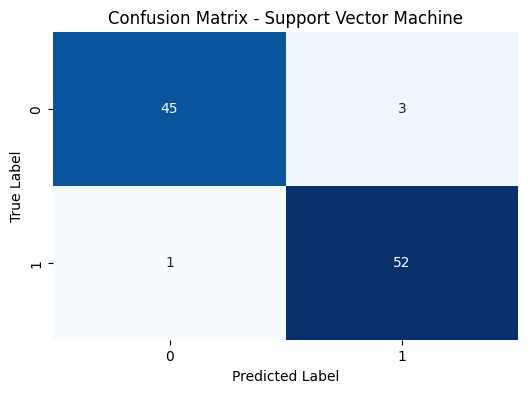


Results for Logistic Regression:
Accuracy: 0.9703
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        48
           1       0.96      0.98      0.97        53

    accuracy                           0.97       101
   macro avg       0.97      0.97      0.97       101
weighted avg       0.97      0.97      0.97       101


Results for Naive Bayes:
Accuracy: 0.9703
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        48
           1       0.96      0.98      0.97        53

    accuracy                           0.97       101
   macro avg       0.97      0.97      0.97       101
weighted avg       0.97      0.97      0.97       101


Results for K-Nearest Neighbors:
Accuracy: 0.8713
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        48
           1       0.86

In [22]:
if X_train is not None:  # Check if splitting was successful
    results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

    for name, metrics in results.items():
        print(f"\nResults for {name}:")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Classification Report:\n{metrics['report']}")

### Analyse des résultats:

- **Régression logistique, Classification naïve bayésienne et AdaBoost :** Ces trois modèles atteignent la plus haute précision (0,9703), ce qui indique qu'ils classent correctement 97 % des échantillons. Leurs rapports de classification montrent également d'excellentes précisions, rappels et scores F1 pour les deux classes.

- **Machine à vecteurs de support (SVM) :** La SVM obtient une précision très proche (0,9604), ce qui en fait également un très bon candidat pour ce jeu de données.

## Fine-tuning des hyperparamètres

La fonction train_and_evaluate_models_with_params_search entraîne et évalue plusieurs modèles de classification, optimisant leurs hyperparamètres via une recherche par grille ou aléatoire.

Pour chaque modèle, elle définit une grille ou un espace de recherche d'hyperparamètres, puis utilise GridSearchCV ou RandomizedSearchCV avec une cross validation à 5 plis pour trouver le meilleur modèle.

Le meilleur estimateur est ensuite entraîné sur l'ensemble des données d'entraînement et évalué sur les données de test à l'aide de la précision, du rapport de classification, de la matrice de confusion et du score F1. Les résultats, incluant les meilleurs hyperparamètres, le meilleur score, le meilleur estimateur et les métriques d'évaluation, sont stockés et renvoyés dans un dictionnaire, accompagnés d'une visualisation de la matrice de confusion.

In [23]:
def train_and_evaluate_models_with_params_search(X_train, X_test, y_train, y_test, search_method="random", random_state=42):
    """Trains and evaluates models with hyperparameter tuning."""

    models = {
        "Logistic Regression": {
            "model": LogisticRegression(max_iter=1000),
            "params": {"C": [0.1, 1, 10], "penalty": ['l1', 'l2'], 'solver': ['liblinear', 'saga']}
        },
        "Naive Bayes": {
            "model": GaussianNB(),
            "params": {}
        },
        "K-Nearest Neighbors": {
            "model": KNeighborsClassifier(),
            "params": {"n_neighbors": [3, 5, 7, 9], "weights": ['uniform', 'distance']}
        },
        "Decision Tree": {
            "model": DecisionTreeClassifier(),
            "params": {"max_depth": [None, 10, 20], "min_samples_split": [2, 5, 10]}
        },
        "Random Forest": {
            "model": RandomForestClassifier(),
            "params": {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]}
        },
        "Gradient Boosting": {
            "model": GradientBoostingClassifier(),
            "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.03, 0.1, 1.0]}
        },
        "AdaBoost": {
            "model": AdaBoostClassifier(),
            "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.03, 0.1, 1.0]}
        },
        "Support Vector Machine": {
            "model": SVC(),
            "params": {"C": [0.1, 1, 10], "kernel": ['linear', 'rbf']}
        },
    }

    results = {}

    for name, model_data in models.items():
        print(f"Training {name}...")
        model = model_data["model"]
        params = model_data["params"]

        if search_method == "grid":
            search = GridSearchCV(model, params, cv=5, scoring='accuracy')
        elif search_method == "random":
            search = RandomizedSearchCV(model, params, cv=5, scoring='accuracy', n_iter=10, random_state=random_state)
        else:
            raise ValueError("Invalid search_method. Use 'grid' or 'random'.")

        if hasattr(model, 'random_state'):
            model.random_state = random_state

        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        y_pred = best_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, zero_division=1)
        cm = confusion_matrix(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        results[name] = {
            "accuracy": accuracy,
            "report": report,
            "confusion_matrix": cm,
            "best_params": search.best_params_,
            "best_score": search.best_score_,
            "best_estimator": search.best_estimator_,
            "f1_score": f1
        }

         # Visualize confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()


    return results

Training Logistic Regression...


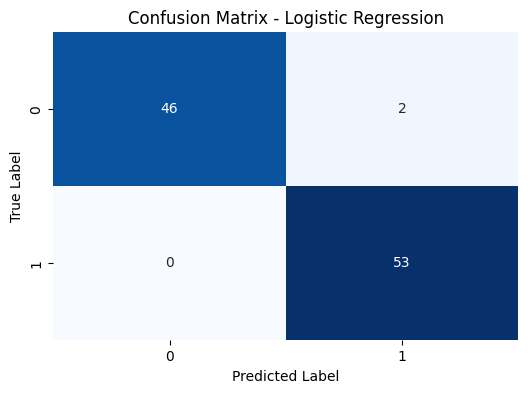

Training Naive Bayes...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


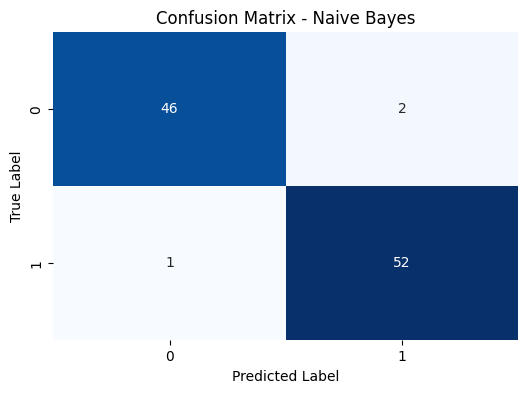

Training K-Nearest Neighbors...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


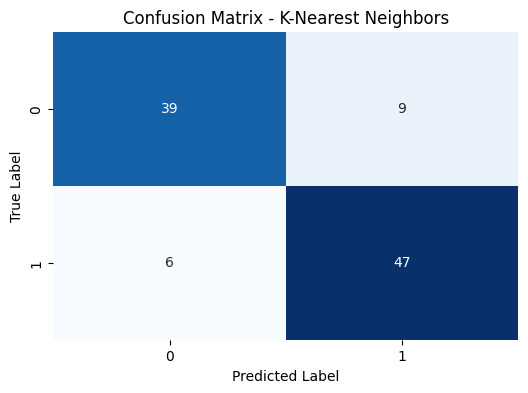

Training Decision Tree...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


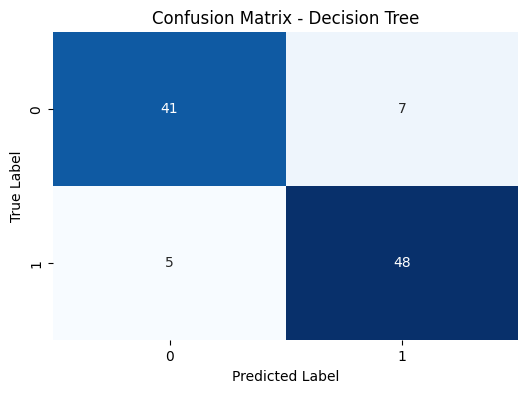

Training Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


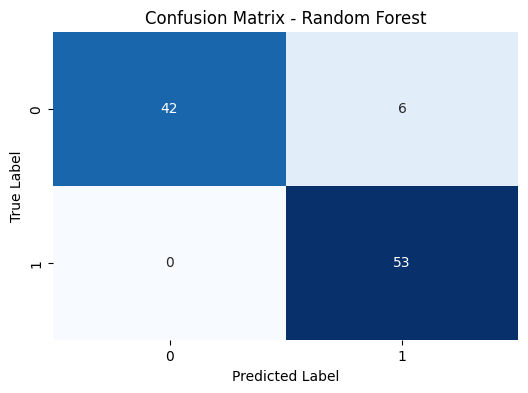

Training Gradient Boosting...


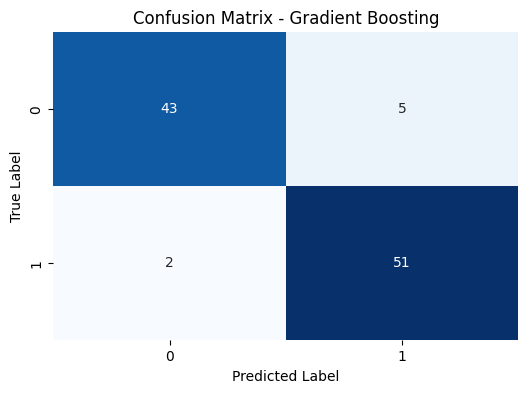

Training AdaBoost...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

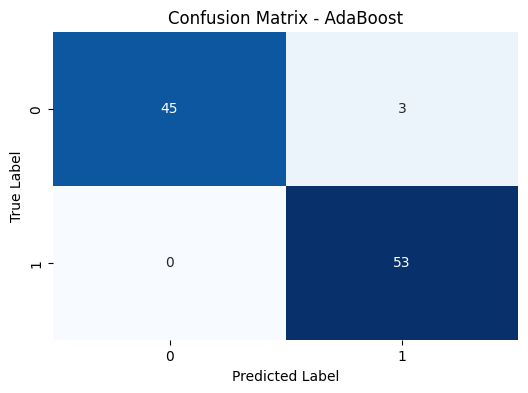

Training Support Vector Machine...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


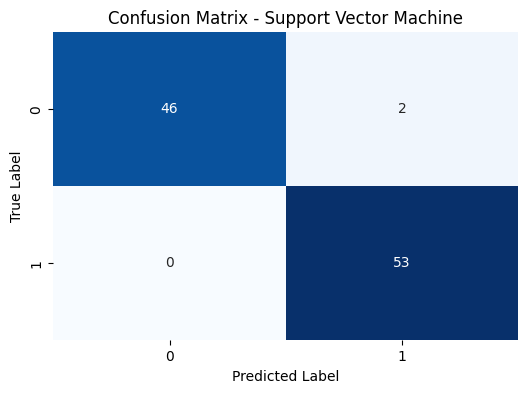


Results for Logistic Regression:
Accuracy: 0.9802
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        48
           1       0.96      1.00      0.98        53

    accuracy                           0.98       101
   macro avg       0.98      0.98      0.98       101
weighted avg       0.98      0.98      0.98       101

Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1}
Best CV Score: 0.9626

Results for Naive Bayes:
Accuracy: 0.9703
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        48
           1       0.96      0.98      0.97        53

    accuracy                           0.97       101
   macro avg       0.97      0.97      0.97       101
weighted avg       0.97      0.97      0.97       101

Best Parameters: {}
Best CV Score: 0.9276

Results for K-Nearest Neighbors:
Accuracy: 0.8515
Classification Report:
  

In [24]:
if X_train is not None:
    results = train_and_evaluate_models_with_params_search(X_train, X_test, y_train, y_test, search_method="random")

    for name, metrics in results.items():
        print(f"\nResults for {name}:")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Classification Report:\n{metrics['report']}")
        print(f"Best Parameters: {metrics['best_params']}")
        print(f"Best CV Score: {metrics['best_score']:.4f}")

Nous allons maintenant extraire le modèle qui a la meilleure metrique F1-score

In [25]:
best_model_name = None
best_model = None
best_f1 = -1  # Initialize best_f1

for name, metrics in results.items():
    if metrics['f1_score'] > best_f1:  # Compare based on F1-score
        best_f1 = metrics['f1_score']
        best_model_name = name
        best_model = metrics["best_estimator"]

if best_model is not None:
    joblib.dump(best_model, 'best_model.joblib')
    print(f"\nThe best model is {best_model_name} with an F1-score of {best_f1:.4f}")


The best model is Logistic Regression with an F1-score of 0.9802


### Essayons de voir si un réseau de neurones peut surpasser le meilleur modèle trouvé

Le réseau de neurones utilise une architecture séquentielle composée de plusieurs blocs de couches denses suivies de dropout.

Les couches denses, ou couches entièrement connectées, connectent chaque neurone d'une couche à chaque neurone de la couche suivante.

L'activation ReLU est utilisée dans la plupart des couches denses pour introduire la non-linéarité, sauf pour une couche qui utilise une activation linéaire.

Les couches de dropout, avec un taux de 0,5, aident à prévenir le surajustement en désactivant aléatoirement la moitié des neurones pendant l'entraînement. De plus, la régularisation L2 est appliquée aux premières couches denses, tandis qu'une combinaison de régularisation L1 et L2 (Elastic Net) est utilisée dans les couches intermédiaires.

Enfin, la couche de sortie utilise une activation softmax pour produire une distribution de probabilité sur les classes, ce qui est approprié pour la classification multiclasse.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 829ms/step - accuracy: 0.4922 - loss: 6.7153 - val_accuracy: 0.8119 - val_loss: 6.0208
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5737 - loss: 5.9130 - val_accuracy: 0.8614 - val_loss: 5.3638
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6296 - loss: 5.2424 - val_accuracy: 0.8812 - val_loss: 4.7695
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5778 - loss: 4.6788 - val_accuracy: 0.8713 - val_loss: 4.2260
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7048 - loss: 4.1597 - val_accuracy: 0.8812 - val_loss: 3.7287
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7754 - loss: 3.6724 - val_accuracy: 0.9109 - val_loss: 3.2551
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7892 - loss: 3.2620 - val_accuracy: 0.9010 - val_loss: 2.8707
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7753 - loss: 2.9476 - val_accuracy: 0.9208 

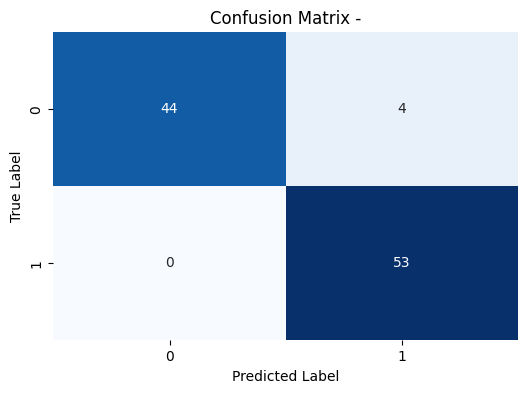

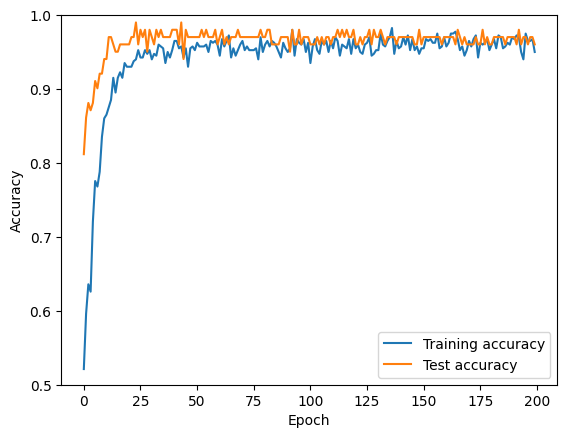

In [26]:
def create_and_train_neural_network(X_train, X_test, y_train, y_test, input_shape, num_classes, epochs=200): # Added input_shape and num_classes
    """Creates and trains a neural network."""

    tf.random.set_seed(42)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.02)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.02)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='linear', kernel_regularizer=l1_l2(l1=0.001, l2=0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer with num_classes units and softmax
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy if y is not one-hot encoded
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

    # Evaluate the model and calculate F1-score
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_pred_prob = model.predict(X_test)  # Get predicted probabilities
    y_pred = np.argmax(y_pred_prob, axis=-1)  # Convert to class labels
    f1 = f1_score(y_test, y_pred, average='weighted')  # Calculate weighted F1-score

    return model, history, f1, accuracy


if X_train is not None:

    input_shape = (X_train.shape[1],)  # Input shape for the neural network
    num_classes = len(np.unique(y_train))  # Number of unique classes in the target


    model, history, f1, accuracy = create_and_train_neural_network(X_train, X_test, y_train, y_test, input_shape, num_classes)


    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Neural Network Test Accuracy: {accuracy:.4f}")
    print(f"Neural Network Test F1-score: {f1:.4f}")

    y_pred = np.argmax(model.predict(X_test), axis=-1) # Convert predictions to class labels
    print(classification_report(y_test, y_pred, zero_division=1))
    cm = confusion_matrix(y_test, y_pred)

    # Visualize confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix -")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


    # Plot training history
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label = 'Test accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()

On n'a pas de problème de biais ni de variance, et pas d'overfitting.

La régression logistique présente un léger avantage en termes de précision et des autres métriques du rapport de classification. Cela suggère que, pour ce problème spécifique, la régression logistique pourrait être un choix légèrement plus approprié.

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,344 (540.41 KB)

 Trainable params: 46,114 (180.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 92,230 (360.28 KB)

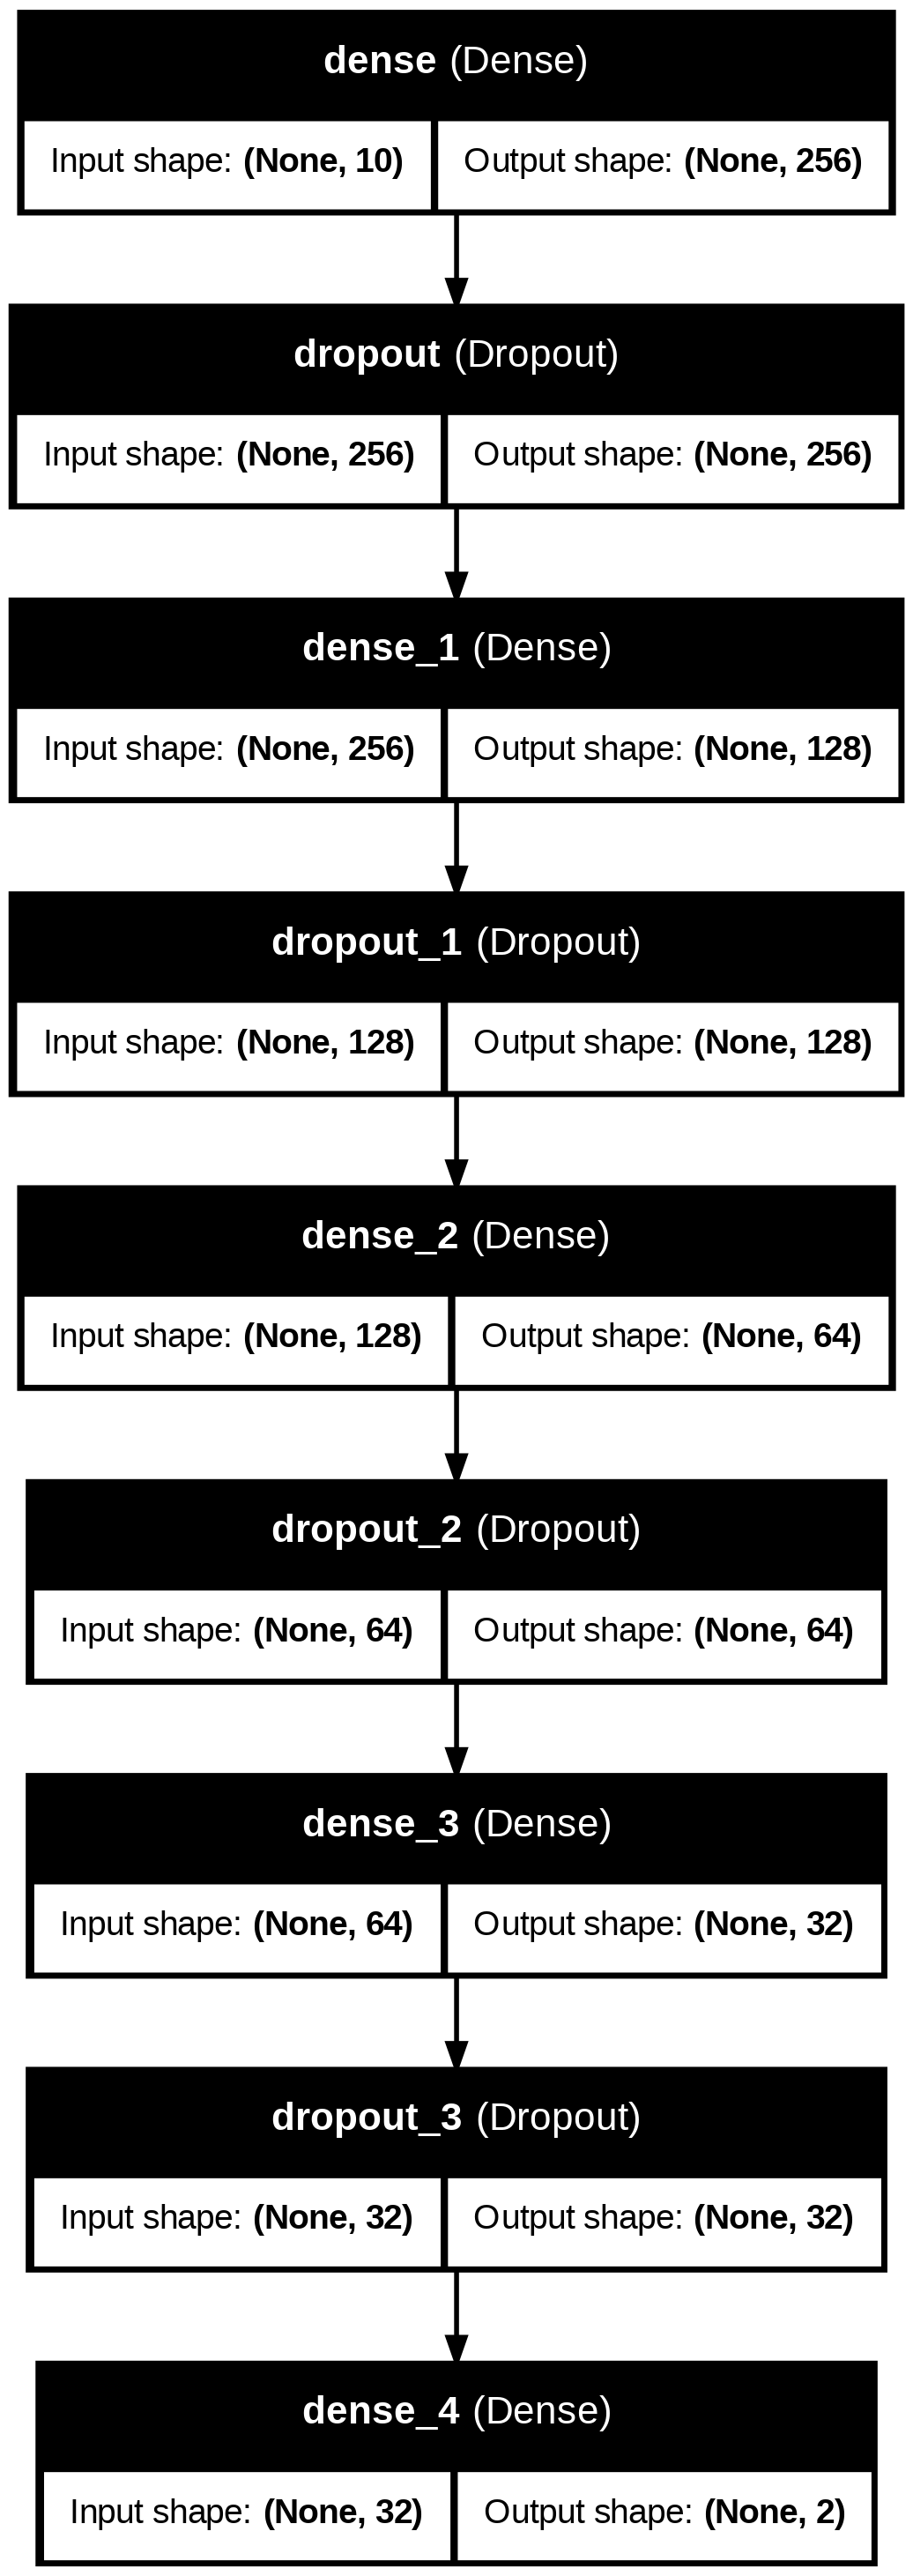

In [28]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)